# Fully-Connected Neural Networks

An autoencoder is primarly used to be trained in an unsupervised fashion. This means the model can be trained just using inputs, and no labels. 

The autoencoder takes the image data, compress it to a small latent space and then reconstruct the image from the compressed latent space values. This is a great way to provide useful features using unsupervised data, for supervised models.

# Import necessary libraries

In [98]:
import random
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
%matplotlib inline

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")
   
# Fixing the random seed
fix_random_seed(4321)

## Loading MNIST dataset


In [99]:
from tensorflow.keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()

In [100]:
print(x_train.shape)

print(y_train.shape)

(60000, 28, 28)
(60000,)


## Transforming MNIST data
This is an important step. We do two important things here.

* Unwrap the (28x28) image into a 1-dimensional 784 vector (because fully-connected networks need a 1-dimensional input).
* Normalize the input by subtracting 128 and dividing by 128. This is because the pixel values are between [0,255].

In [101]:
norm_x_train = ((x_train - 128.0) / 128.0).reshape([-1,784])

## Extracting a small sample and plotting the data

Here we will plot some of the data to get an idea of what we are dealing with.

In [102]:
sample_images, sample_labels = [], []
for i, (img, lbl) in enumerate(zip(x_train, y_train)):
    sample_images.append(img)
    sample_labels.append(lbl)
    if i >= 9:
        break

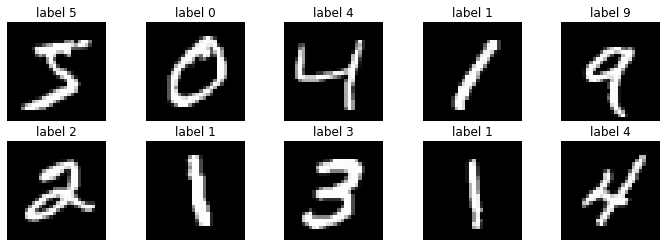

In [103]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(2, 5, figsize=(12,4))
for i, (img, lbl) in enumerate(zip(sample_images, sample_labels)):
    r, c = i//5, i%5
    axes[r, c].imshow(img, cmap='gray')
    axes[r, c].axis('off')
    axes[r, c].set_title('label {}'.format(lbl))

## Creating corrupted images 

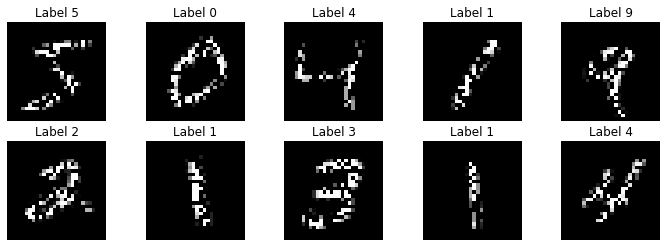

In [104]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x_train_sample = x_train[:10]
y_train_sample = y_train[:10]

def generate_masked_inputs(x, p, seed=None):
    """ This function applies a binary mask to the input and generate corrupted images """
    # Fixing the seed
    if seed:
        np.random.seed(seed)
    
    # Generating a mask using the binomial distribution
    mask = np.random.binomial(n=1, p=p, size=x.shape).astype('float32')
#     mask = np.random.uniform(1, p, x.shape)
    return x * mask

# Create a training dataset of corrupted images
masked_x_train_sample = generate_masked_inputs(x_train_sample, 0.5)

# Plotting some of the images
f, axes = plt.subplots(2, 5, figsize=(12,4))
for i, (img, lbl) in enumerate(zip(masked_x_train_sample, y_train_sample)):
    r, c = i//5, i%5
    axes[r,c].imshow(img,cmap='gray')
    axes[r,c].axis('off')
    axes[r,c].set_title("Label {}".format(lbl))

## Defining the autoencoder model

Now it's time to define the model. We will define a simple autoencoder model. This model has the following layers.

* A Dense layer with 64 nodes and `relu` activation
* A Dense layer with 32 nodes and `relu` activation
* A Dense layer with 64 nodes and `relu` activation
* A Dense layer with 784 nodes and `tanh` activation (i.e. the layer that reconstructs the images)

Finally, we will compile the model with mean squared error (mse) loss and the `adam` optimizer.

In [105]:
from tensorflow.keras import layers, models
from tensorflow import keras
import tensorflow.keras.backend as K

K.clear_session()

autoencoder = keras.Sequential([
    layers.Dense(64, activation = 'relu', input_shape = (784,)),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(784, activation = 'tanh')
])

autoencoder.compile(loss = 'mse', optimizer = 'adam')
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 784)               50960     
                                                                 
Total params: 105,392
Trainable params: 105,392
Non-trainable params: 0
_________________________________________________________________


## Training the model

Training the model is simple. You call the `fit()` method with the correct data. Note how the input and the output to the model are the same. This is because we are trying to construct the exact same input as the output of the model. We are using a batch size of 64 and 10 epochs.

In [106]:
# Generating the corrupted version of norm_x_train to be used as training inputs
masked_x_train = generate_masked_inputs(norm_x_train, 0.5, seed=1024)
# Fit the model
history = autoencoder.fit(masked_x_train, norm_x_train, batch_size=64, epochs=10)

Epoch 1/10
938/938 [==============================] - 1s 1ms/step - loss: 0.1500
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.1012
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0932
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0894
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0858
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0831
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0807
Epoch 8/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0789
Epoch 9/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0771
Epoch 10/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0756


## Plotting the loss over time

It is quite clear that our model is learning. You can see the loss steadily going down.

Text(0.5, 1.0, 'Autoencoder reconstruction loss for MNIST dataset')

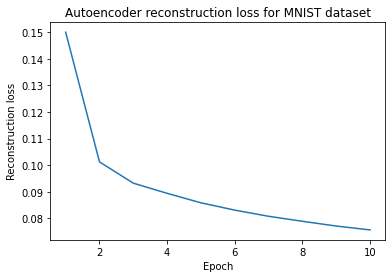

In [107]:
# Plotting the loss
plt.plot(np.arange(1,11), history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.title("Autoencoder reconstruction loss for MNIST dataset")


## Predicting restorations of the corrupted images from the network

Great we have a trained model. Now let's get a small sample of images, corrupt them with a mask and then ask the model to predict the correct restoration of the images.

In [108]:
x_train_sample = x_train[:10]
y_train_sample = y_train[:10]

masked_x_train_sample = generate_masked_inputs(x_train_sample, 0.5, seed=2048)
norm_masked_x = ((x_train - 128.0) / 128.0).reshape(-1, 784)

y_pred = autoencoder.predict(norm_masked_x)

1875/1875 [==============================] - 1s 599us/step


In [109]:
print(y_pred)
print('y_pred has shape: {}'.format(y_pred.shape))

[[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -0.9999997 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
y_pred has shape: (60000, 784)


## Plotting the model predictions

`y_pred` is holding the predictions we made. Let's plot them now and visually inspect if our model has done a good job.

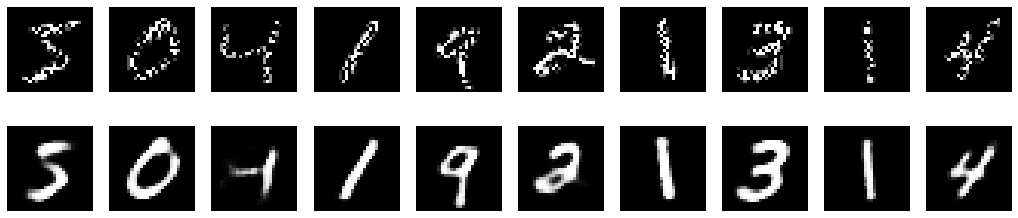

In [110]:
# Plotting the corrupted and restored images side-by-side
f, axes = plt.subplots(2, 10, figsize=(18,4))
for i, (img, res) in enumerate(zip(masked_x_train_sample, y_pred)):
    r1, c1 = 0, i
    r2, c2 = 1, i
    axes[r1,c1].imshow(img,cmap='gray')
    axes[r1,c1].axis('off')
    
    res = ((res * 128.0)+128.0).reshape(28,28)
    axes[r2,c2].imshow(res,cmap='gray')
    axes[r2,c2].axis('off')